# 프로젝트: 인물 모드 문제점 찾기
만들면서 뭔가 이상한 점이 느껴졌을 것이다. 프로젝트를 통해 찾아보자.

## Step 1. 인물모드 직접 해 보기
---
* 셀카를 이용해서 오늘 내용을 수행해보자. 아래와 같은 이미지를 얻어야 한다. 최소 3장 이상의 인물모드 사진을 만들어보자.
* 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것이다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아보자.
* 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경합성을 시도해 볼 수도 있을 것이다.

<img src="./image/node.png" alt="Node" />

### 사진 2장을 준비하자.
---

* __1번 사진 (고양이 사진)__

    - _고양이 사진에는 배경사진을 추가할 것이다._

<img src="./image/cat.jpg" alt="Cat"  width="50%" />


* __2번 사진 (애니매이션 사진)__

    - _애니매이션도 blur 처리가 되는지 궁금해서 시도 해볼 것이며 잘 적용이 된다면, 문제점을 찾아내는 과정을 진행 할 것이다._

<img src="./image/your_name.jpg" alt="Anime"  width="50%" />


### 필요한 라이브러리 가져오기
---

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### 1번 사진 (고양이 사진)

#### 준비한 이미지 읽기
---

In [3]:
import os
img_path = os.getenv('HOME')+'/AIFFEL/Exploration/E10_Portrait_mode/image/cat.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(460, 464, 3)


#### 셸로우 포커스 만들기 (1) 시맨틱 세그멘테이션 다뤄보기
---
일단 원활한 진행을 위해 함수를 만들자.

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

`preprocess()`는 전처리, `run()`은 실제로 세그멘테이션을 하는 함수이다.

사전에 학습된 __가중치(pretrained weight)__를 불러오자.

In [5]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/AIFFEL/Exploration/P10_Portrait_mode/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj10/AIFFEL/Exploration/P10_Portrait_mode/human_segmentation/models
model loaded successfully!


구글이 제공하는 `deeplabv3_mnv2_pascal_train_aug_2018_01_29` weight을 다운로드 받고 `DeepLabModel` 을 초기화했다. 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전이다.

첫 단계에서 준비한 이미지를 네트워크에 입력한다.

In [6]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(460, 464, 3) (508, 513, 3) 12


`img_orig` 의 크기는 `460x464` 이고 `img_resized` 의 크기는 `508x513` 이 출력되었다. 입력 이미지 크기가 달라지면 resize 크기도 조금씩 달라질 것이다. (cv2는 채널을 HWC 순서로 표시한다는 점 주목!)

구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었다. 제공하는 라벨 종류는 아래와 같다.

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

이 중 고양이(`cat`) 라벨, 즉 `8`를 가진 영역만 검출해 내고 싶다. 마스크를 만들고 시각화해 보자.

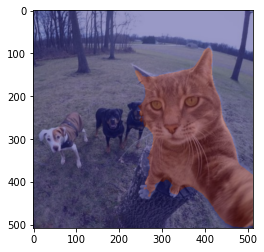

In [8]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

사람을 뜻하는 `15` 외 예측은 0으로 만들었다. 그럼 예측된 세그멘테이션 이미지(map)는 최대값이 15가 된다. 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 한다. `applyColorMap()` 함수로 색을 적용하고 이미지를 화면에 출력한다.

#### 셸로우 포커스 만들기 (2) 세그멘테이션 결과를 원래 크기로 복원하기
---
DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했다. 따라서 출력도 resize 된 입력 크기와 같게 나오게 된다.

세그멘테이션 결과(mask)를 원래 크기로 복원해 보자.

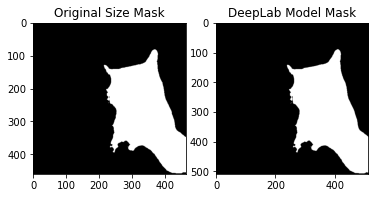

In [9]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

`cv2.resize()` 함수를 이용한다. 크기를 키울 때 보간(`interpolation`) 을 고려해야 하는데, `cv2.INTER_NEAREST`를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 `cv2.INTER_LINEAR` 를 사용한다.

결과적으로 `img_mask_up` 은 경계가 블러된 픽셀값 0~255의 이미지를 얻는다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(`threshold`)을 설정한다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법이다.

__결과__


<img src="./image/mask_cat.png" alt="Mask up" width="50%"/>

좌표를 통해 이미지의 크기가 다른 것을 확인할 수 있다.

#### 셸로우 포커스 만들기 (3) 배경 흐리게 하기
---
배경을 흐리게 하기 위해서 세그멘테이션 마스크를 이용해서 배경만 추출하자.

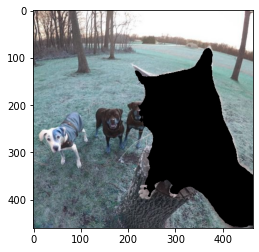

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

이 이미지를 블러(`blur`)하면 배경이 흐리게 처리된 영상을 얻을 수 있다.

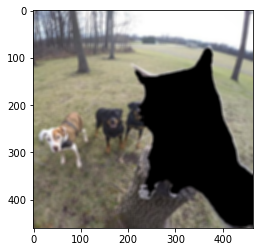

In [11]:
img_bg_blur = cv2.blur(img_bg, (7,7))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 셸로우 포커스 만들기 (4) 흐린 배경과 원본 영상 합성
---
이제 배경 영상과 사람 영상을 합쳐보자.

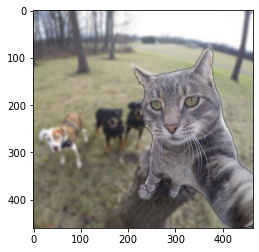

In [12]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

이미지 저장

In [13]:
img_path = os.getenv('HOME')+'/AIFFEL/Exploration/E10_Portrait_mode/image/cat_final.png'

cv2.imwrite(img_path, img_concat)

True

세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용한다.

__완성 사진__

<img src="./image/cat_final.png" alt="Final" />

### 1번 고양이 사진에서 배경 바꾸어보기

배경이미지로는 이 이미지를 사용할 것이다.
<img src="./image/bg.jpg" alt="Background image" width="50%"/>

#### 이미지 불러오기
---

In [14]:
cat_path = os.getenv('HOME')+'/AIFFEL/Exploration/E10_Portrait_mode/image/cat.jpg'
cat_img_orig = cv2.imread(cat_path)
bg_path = os.getenv('HOME')+'/AIFFEL/Exploration/E10_Portrait_mode/image/bg.jpg'
bg_img_orig = cv2.imread(bg_path)

print (cat_img_orig.shape, bg_img_orig.shape)

(460, 464, 3) (1080, 1080, 3)


#### 이미지 리사이즈
---
여기서 중요한 것은 배경이미지의 크기도 같이 조절해주어야 한다는 점이다.

참조: [cv2 resize 함수](https://076923.github.io/posts/Python-opencv-8/)

In [15]:
cat_img_resized, seg_map = MODEL.run(cat_img_orig)
bg_img_resized = cv2.resize(bg_img_orig, (464, 460))

print (cat_img_resized.shape, bg_img_resized.shape, seg_map.max())

(508, 513, 3) (460, 464, 3) 12


#### 시맨틱 세그멘테이션
---

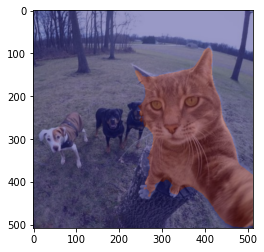

In [16]:
cat_img_show = cat_img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
cat_img_mask = seg_map * (255/seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 마스크업
---

In [17]:
cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

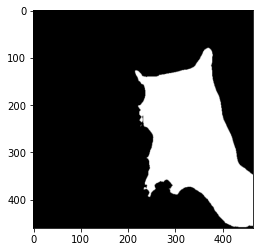

In [18]:
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)

plt.imshow(cv2.cvtColor(cat_img_mask_color, cv2.COLOR_BGR2RGB))
plt.show()

#### 원본과 합성사진 비교하기
---

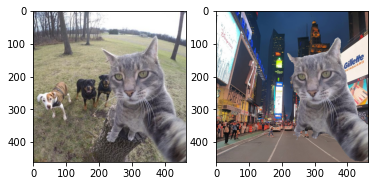

In [19]:
ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,2,2)
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, bg_img_resized)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))

plt.show()

이미지 저장

In [20]:
img_path = os.getenv('HOME')+'/AIFFEL/Exploration/E10_Portrait_mode/image/manhattan_cat_final.png'

cv2.imwrite(img_path, cat_img_concat)

True

<img src="./image/manhattan_cat_final.png" alt="manhattan_cat" width="50%"/>

### 2번 사진 (애니매이션 사진)

#### 준비한 이미지 읽기
---

In [21]:
img_path = os.getenv('HOME')+'/AIFFEL/Exploration/E10_Portrait_mode/image/your_name.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1334, 750, 3)


#### 셸로우 포커스 만들기 (1) 시맨틱 세그멘테이션 다뤄보기
---
구글이 제공하는 `deeplabv3_mnv2_pascal_train_aug_2018_01_29` weight을 다운로드 받고 `DeepLabModel` 을 초기화했다. 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전이다.

첫 단계에서 준비한 이미지를 네트워크에 입력한다.

In [22]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1334, 750, 3) (513, 288, 3) 15


`img_orig` 의 크기는 `1004x670` 이고 `img_resized` 의 크기는 `513x342` 이 출력되었다. 입력 이미지 크기가 달라지면 resize 크기도 조금씩 달라질 것이다. (cv2는 채널을 HWC 순서로 표시한다는 점 주목!)

구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었다. 제공하는 라벨 종류는 아래와 같다.

In [23]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

이 중 사람(`person`) 라벨, 즉 `15`를 가진 영역만 검출해 내고 싶다. 마스크를 만들고 시각화해 보자.

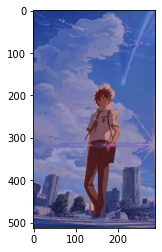

In [24]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

오! 애니매이션도 사람을 인식하는 걸 볼 수 있다. 시도에 보람이 있구만ㅎㅎ

사람을 뜻하는 `15` 외 예측은 0으로 만들었다. 그럼 예측된 세그멘테이션 이미지(map)는 최대값이 15가 된다. 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 한다. `applyColorMap()` 함수로 색을 적용하고 이미지를 화면에 출력한다.

#### 셸로우 포커스 만들기 (2) 세그멘테이션 결과를 원래 크기로 복원하기
---
DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했다. 따라서 출력도 resize 된 입력 크기와 같게 나오게 된다.

세그멘테이션 결과(mask)를 원래 크기로 복원해 보자.

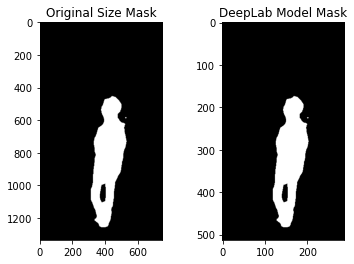

In [25]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

`cv2.resize()` 함수를 이용한다. 크기를 키울 때 보간(`interpolation`) 을 고려해야 하는데, `cv2.INTER_NEAREST`를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 `cv2.INTER_LINEAR` 를 사용한다.

결과적으로 `img_mask_up` 은 경계가 블러된 픽셀값 0~255의 이미지를 얻는다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(`threshold`)을 설정한다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법이다.

__결과__


<img src="./image/mask_up.png" alt="Mask up" width="50%"/>

좌표를 통해 이미지의 크기가 다른 것을 확인할 수 있다.

#### 셸로우 포커스 만들기 (3) 배경 흐리게 하기
---
배경을 흐리게 하기 위해서 세그멘테이션 마스크를 이용해서 배경만 추출하자.

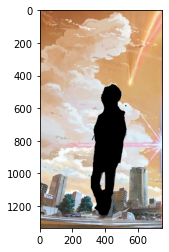

In [26]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

이 이미지를 블러(`blur`)하면 배경이 흐리게 처리된 영상을 얻을 수 있다.

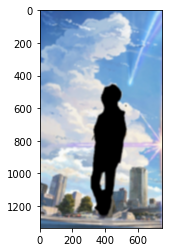

In [27]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 셸로우 포커스 만들기 (4) 흐린 배경과 원본 영상 합성
---
이제 배경 영상과 사람 영상을 합쳐보자.

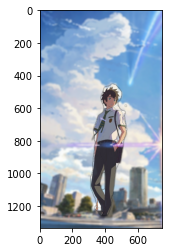

In [28]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

이미지 저장

In [29]:
img_path = os.getenv('HOME')+'/AIFFEL/Exploration/E10_Portrait_mode/image/your_name_final.png'

cv2.imwrite(img_path, img_concat)

True

세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용한다.

__완성 사진__
<img src="./image/your_name_final.png" alt="your name final" />

솔직히 너무 이상한 점이 많다. 다음 스텝에서 이상한 점들을 찾고 해결해보자.

## Step 2. 사진에서 문제점 찾기
---
그러나 사진에는 무언가 문제점이 있을 것이다.

아래 사진에도 문제점이 몇가지 있다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지지 않고 나온다던가 하는 경우이다. 그 외 다른 문제들이 눈에 띄일 것이다. 아래 사진에는 이상한 점이 최소 2개 이상 더 있다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해보자.

추가로 만들어 낸 인물 모드 사진 중 하나에서라도 이상한 위치를 찾아 아래 사진처럼 표시해보자.

<img src="./image/node2.png" alt="Node" />

### 문제점찾기
---
<img src="./image/problem.png" alt="Problem" />

## Step 3. 해결 방법을 제안해 보기
---
아주 간단히 멋진 카메라앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금같은 완성도로는 어림도 없다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 우리는 답을 찾아내야 한다.

단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 한다.

### 세그멘테이션의 한계
Semantic segmentation의 부정확성이 여러가지 문제를 발생시키는 주요 원인이다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘들다.

### 피사계 심도 이해하기
우선 피사계심도의 개념부터 명확히 이해해보자.

참고자료 : [https://ggyul.tistory.com/12](https://ggyul.tistory.com/12)

### 3D Depth Camera 활용하기
카메라 2개를 통해 생성한 3d 영상으로 인물모드를 더 정확하게 만들 수 있을까? 카메라 1대가 찍은 영상에서 semantic segmentation을 시도하였고, 그 결과가 정확하지 않았다. 요즘 스마트폰의 카메라는 렌즈가 2개 달려다. 왜 굳이 그렇게까지 하는지 아래 링크를 보면서 이해해보자.

참고자료 : [https://m.blog.naver.com/panoptics/221336152952](https://m.blog.naver.com/panoptics/221336152952)

### 깊이 영상(Depth image) 활용하기
하지만 꼭 카메라가 2개여야 할까? 아래 이미지는 Struct2Depth 라는 기법을 소개한 Google Brain의 논문에 있는 이미지이다. 세번째 컬럼이 보다 명확하게 depth에 따른 물체인식을 보여 주는데, 이것은 LiDAR가 없이도 아주 정확한 segmentation을 동반한 depth sensor가 가능함을 보여준다.

참고자료 : [https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6](https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6)<br>
참고자료 : [https://sites.google.com/view/struct2depth](https://sites.google.com/view/struct2depth)



<img src="./image/ir.png" alt="IR" />

### IR(적외선)을 활용한 사례
구글 pixel4에 IR 카메라가 달려있는데, 이를 통해 보다 멋진 3d depth sensing이 가능다고 한다.

참고자료 : [https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html](https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html)

엔지니어로서 본인이 선택한 솔루션을 잘 설명해야한다. 가능하다면 순서도(Flow Chart)를 활용하면 좋다.

### medianblur로 문제점 해결하기
---
Struct2Depth를 이용하여 문제점을 해결하고 싶었으나 github 접속이 안되고 구글링으로 찾아봐도 좋은 정보가 없어서 `medianblur`함수를 사용해서 해결하고자 한다.

참조한 블로그: [파이썬 OpenCV 이미지 필터링 알아보기](https://jvvp.tistory.com/1032)

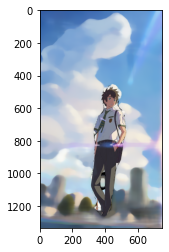

In [34]:
img_path = os.getenv('HOME')+'/AIFFEL/Exploration/E10_Portrait_mode/image/your_name.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

img_bg_blur = cv2.medianBlur(img_bg, 45)

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

이미지 저장

In [35]:
img_path = os.getenv('HOME')+'/AIFFEL/Exploration/E10_Portrait_mode/image/your_name_medianBlur.png'

cv2.imwrite(img_path, img_concat)

True

<img src="./image/your_name_medianBlur.png" alt="medianBlur" />

### 문제 해결 평가(프로젝트 회고 포함)
---
* 애니메이션 사진의 특징중 하나가 머리카락이 뾰족뾰족한 것인데, 이것 때문에 머리 쪽의 blur처리가 경계선을 정확하게 지키지 못한 것 같다.(다른 부분의 문제점들도 비슷한 문제이다.)
* 사실 medianblur 함수를 이용한 것은 Semantic segmentation의 부정확성을 해결해주지는 못한다. 왜냐하면 모델을 다른 것을 사용한 것이 아니라 cv2의 blur처리 하는 함수만 좀 부드럽게 변경한 것이기 때문이다.
* 좀 더 시간이 있다면 depth에 따른 물체인식이 정확한 모델을 사용해서 프로젝트를 해보고 싶다.

## 루브릭
---
* 인물모드 사진을 성공적으로 제작하였다.<br>
(_아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다._)

    * __애니메이션 인물 모드 사진, 고양이 사진, 고양이 배경 전환 사진 각각 1장 제작하였다.__

* 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.<br>
( _인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다._)
    
    * __위 애니메이션 인물 모드 사진에서 나온 문제점들을 지적한 사진을 제출했다.__

* 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.<br>
(_추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다._)
    
    * __추가적인 depth정보를 활용하지는 못했지만, 대안으로 cv2의 medianBlur함수를 사용해 조금이나마 오류를 보완하고자 했다.__